# Линейна спектрална двойка, свойства и преобразуване

#### Import required libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

#### LPC Analysis and Visualization of Roots

##### **Step 1. Load Audio Signal**
The code reads an audio file using `wavfile.read()` and retrieves the sample rate and audio signal data. 
- If the audio signal is stereo (having multiple channels), it is converted to mono by averaging the channels. This is done to simplify further processing, as LPC analysis typically operates on single-channel signals.

##### **Step 2. Set LPC Parameters**
An LPC order is defined, which specifies the number of coefficients to be calculated. 
- The LPC order affects the model's complexity and accuracy, with higher orders capturing more detail but potentially introducing overfitting.

##### **Step 3. Calculate Autocorrelation**
The autocorrelation of the audio signal is computed using `np.correlate()`, which measures how similar the signal is to itself at different time lags.
- The resulting autocorrelation values are then trimmed to retain only the first `order + 1` coefficients, which are necessary for LPC analysis.

##### **Step 4. Implement Levinson-Durbin Algorithm**
This section uses the Levinson-Durbin recursion to compute the LPC coefficients based on the autocorrelation values.
- The algorithm initializes arrays for LPC coefficients and prediction error energy. It iteratively calculates reflection coefficients and updates the LPC coefficients and error energy, which helps in minimizing the prediction error for the signal.

##### **Step 5. Convert LPC to LSP Frequencies**
The LPC coefficients are normalized, and the corresponding polynomials \( P(z) \) and \( Q(z) \) are constructed.
- The coefficients are reversed, and then added and subtracted to form the two polynomials. This step is crucial for obtaining the line spectral pairs (LSP), which are a more stable representation of the LPC coefficients.

##### **Step 6. Plotting Roots on the Unit Circle**
A plot is created to visualize the roots of the \( P(z) \) and \( Q(z) \) polynomials on the unit circle in the complex plane.
- The roots are calculated using `np.roots()`, and both sets of roots are plotted. The unit circle serves as a reference for analyzing the stability and characteristics of the system represented by the LPC coefficients.

##### **Step 7. Show the Plot**
Finally, the code customizes the plot by adding grid lines, labels, a title, and setting axis limits.
- The plot is displayed to provide visual insight into the distribution of roots, which can be used to assess the stability and performance of the LPC model.


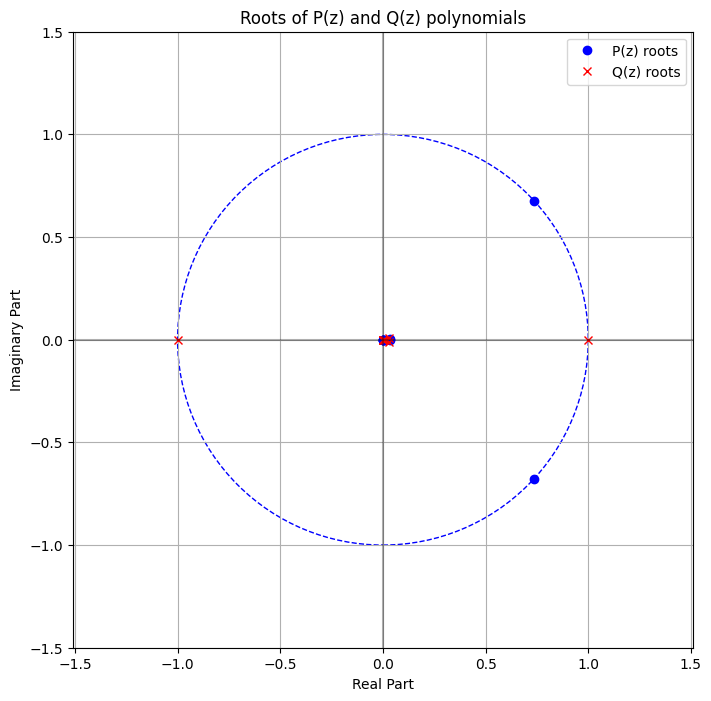

In [10]:
# Load a real audio signal
file_path = "speech_samples/speech_test_02.wav"

sample_rate, audio_signal = wavfile.read(file_path)  # Change this path to your .wav file
if audio_signal.ndim > 1:  # If stereo, convert to mono by averaging the channels
    audio_signal = np.mean(audio_signal, axis=1)

# Parameters for LPC
order = 14  # You can adjust the LPC order as needed

# Autocorrelation method for LPC
n = len(audio_signal)
r = np.correlate(audio_signal, audio_signal, mode='full')[n-1:]
R = r[:order + 1]

# Levinson-Durbin recursion
A = np.zeros(order + 1)
E = np.zeros(order + 1)
A[0] = 1.0
E[0] = R[0]

for i in range(1, order + 1):
    k = R[i]
    for j in range(1, i):
        k -= A[j] * R[i-j]
    k /= E[i-1]
    A[i] = k
    
    for j in range(1, i):
        A[j] -= k * A[i-j]
    
    E[i] = (1 - k * k) * E[i-1]

# Convert LPC coefficients to LSP frequencies
if A[0] != 1:
    A = A / A[0]

order = len(A) - 1
rev_coeffs = np.flipud(A)

# Initialize P and Q polynomials
P = np.zeros(order + 2)
Q = np.zeros(order + 2)

# Construct P polynomial
P[0:order + 1] = A
P[order + 1:] = 0  # Ensure proper size for the addition
P += np.concatenate((rev_coeffs, [0]))  # Add reversed coefficients with an extra zero
P /= 2

# Construct Q polynomial
Q[0:order + 1] = A
Q[order + 1:] = 0  # Ensure proper size for the subtraction
Q -= np.concatenate((rev_coeffs, [0]))  # Subtract reversed coefficients with an extra zero
Q /= 2

# Plotting roots on the unit circle
plt.figure(figsize=(8, 8))

# Plot unit circle
circle = plt.Circle((0, 0), 1, fill=False, color='blue', linestyle='--')
plt.gca().add_artist(circle)

# Find and plot roots
p_roots = np.roots(P)
q_roots = np.roots(Q)

plt.plot(np.real(p_roots), np.imag(p_roots), 'bo', label='P(z) roots')
plt.plot(np.real(q_roots), np.imag(q_roots), 'rx', label='Q(z) roots')

# Set plot properties
plt.grid(True)
plt.axis('equal')
plt.title("Roots of P(z) and Q(z) polynomials")
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.legend()
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# Set axis limits
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()


#### Demonstrate Stability of LSP with Quantizatio

#### Step 1: Load Audio Signal
- The audio file is loaded using `wavfile.read()`. If it’s a stereo signal, it is converted to mono by averaging the two channels.

#### Step 2: Calculate LPC Coefficients
- The LPC coefficients are computed using the autocorrelation method. The algorithm is implemented using the Levinson-Durbin recursion, which calculates the coefficients based on the autocorrelation values.

#### Step 3: Quantize LPC Coefficients
- The LPC coefficients are quantized to a defined number of levels. The maximum absolute value of the LPC coefficients is used to normalize the coefficients before quantization, ensuring they fall within the range of quantization levels.

#### Step 4: Convert LPC to LSP Frequencies
- The LSP frequencies are calculated from both the original and quantized LPC coefficients using polynomial root-finding. The P and Q polynomials are constructed based on the LPC coefficients, and the roots are found to obtain the LSP frequencies.

#### Step 5: Plot Results
- Two subplots are created to visualize the LSP frequencies obtained from the original LPC coefficients and the quantized LPC coefficients, allowing for comparison and analysis of the impact of quantization on stability.

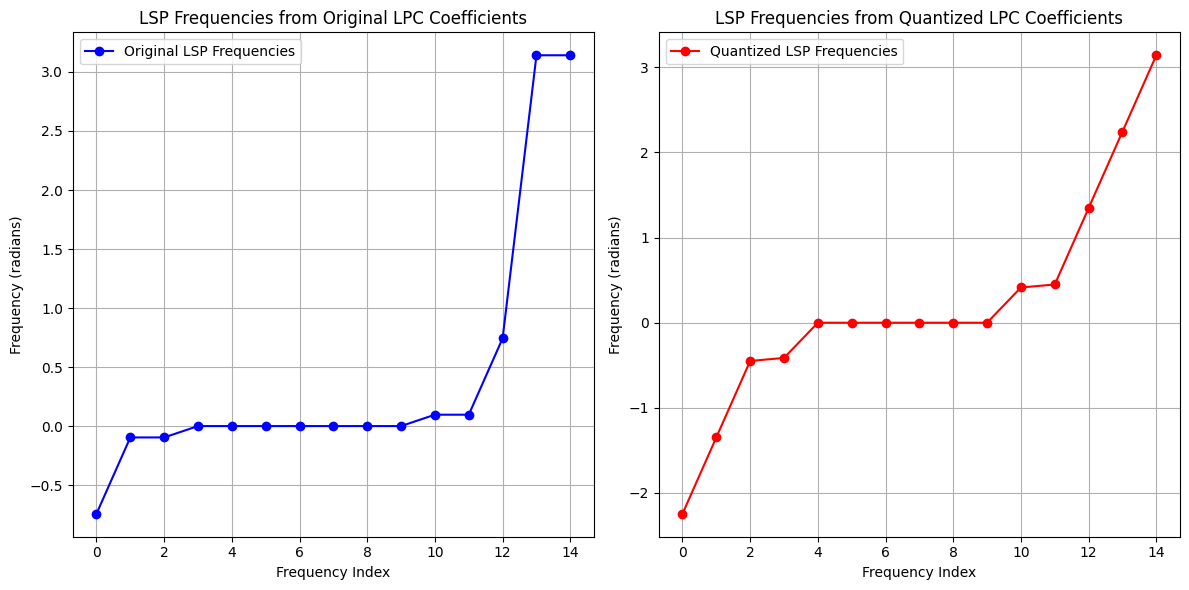

In [14]:
# Load a real audio signal
file_path = "speech_samples/speech_test_02.wav"

sample_rate, audio_signal = wavfile.read(file_path)  # Change this path to your .wav file
if audio_signal.ndim > 1:  # If stereo, convert to mono by averaging the channels
    audio_signal = np.mean(audio_signal, axis=1)

# Define LPC order
order = 14  # You can adjust the LPC order as needed

# Step 1: Calculate LPC coefficients using autocorrelation method
n = len(audio_signal)
r = np.correlate(audio_signal, audio_signal, mode='full')[n-1:]
R = r[:order + 1]
A = np.zeros(order + 1)
E = np.zeros(order + 1)
A[0] = 1.0
E[0] = R[0]

for i in range(1, order + 1):
    k = R[i]
    for j in range(1, i):
        k -= A[j] * R[i-j]
    k /= E[i-1]
    A[i] = k
    for j in range(1, i):
        A[j] -= k * A[i-j]
    E[i] = (1 - k * k) * E[i-1]

# Step 2: Quantize LPC coefficients
num_levels = 16  # Define number of quantization levels
max_val = np.max(np.abs(A))
quantized_lpc = np.round((A / max_val) * (num_levels - 1)) * (max_val / (num_levels - 1))

# Step 3: Convert LPC to LSP
# Normalize LPC coefficients
if A[0] != 1:
    A /= A[0]

# Create reversed coefficients
rev_coeffs = np.flipud(A)

# Initialize P and Q polynomials
P = np.zeros(order + 2)
Q = np.zeros(order + 2)

# Construct P polynomial
P[0:order + 1] = A
P[order + 1:] = 0
P += np.concatenate((rev_coeffs, [0]))
P /= 2

# Construct Q polynomial
Q[0:order + 1] = A
Q[order + 1:] = 0
Q -= np.concatenate((rev_coeffs, [0]))
Q /= 2

# Step 4: Calculate LSP frequencies from LPC and quantized LPC
lsp_frequencies = np.angle(np.roots(P))
quantized_lsp_frequencies = np.angle(np.roots(np.concatenate(([1], quantized_lpc))))

# Step 5: Plot results
plt.figure(figsize=(12, 6))

# Plot LSP frequencies from LPC
plt.subplot(1, 2, 1)
plt.plot(np.sort(lsp_frequencies), 'bo-', label='Original LSP Frequencies')
plt.title('LSP Frequencies from Original LPC Coefficients')
plt.xlabel('Frequency Index')
plt.ylabel('Frequency (radians)')
plt.grid()
plt.legend()

# Plot LSP frequencies from quantized LPC
plt.subplot(1, 2, 2)
plt.plot(np.sort(quantized_lsp_frequencies), 'ro-', label='Quantized LSP Frequencies')
plt.title('LSP Frequencies from Quantized LPC Coefficients')
plt.xlabel('Frequency Index')
plt.ylabel('Frequency (radians)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


### Interpolation Between Two Sets of LSP Frequencies

#### Step 1: Load Audio Signal
- The audio file is loaded using `wavfile.read()`. If it’s a stereo signal, it is converted to mono by averaging the two channels.

#### Step 2: Calculate LPC Coefficients
- The LPC coefficients are computed using the autocorrelation method, utilizing the Levinson-Durbin recursion to calculate coefficients based on the autocorrelation values.

#### Step 3: Convert LPC to LSP Frequencies
- The LSP frequencies are calculated from the LPC coefficients. P and Q polynomials are constructed based on the LPC coefficients, and the roots are found to obtain the LSP frequencies.

#### Step 4: Create a Second Set of LSP Frequencies
- A second set of LSP frequencies is created. In this example, random noise is added to the original LSP frequencies to simulate a second frequency set.

#### Step 5: Interpolate Between Two Sets of LSP Frequencies
- Linear interpolation is performed between the two sets of LSP frequencies. The interpolation is done using a range of alpha values between 0 and 1, generating several intermediate frequency sets.

#### Step 6: Visualize Results
- The original, second, and interpolated LSP frequencies are plotted for visualization. This allows for an examination of the smoothness of the transitions between the frequency sets.

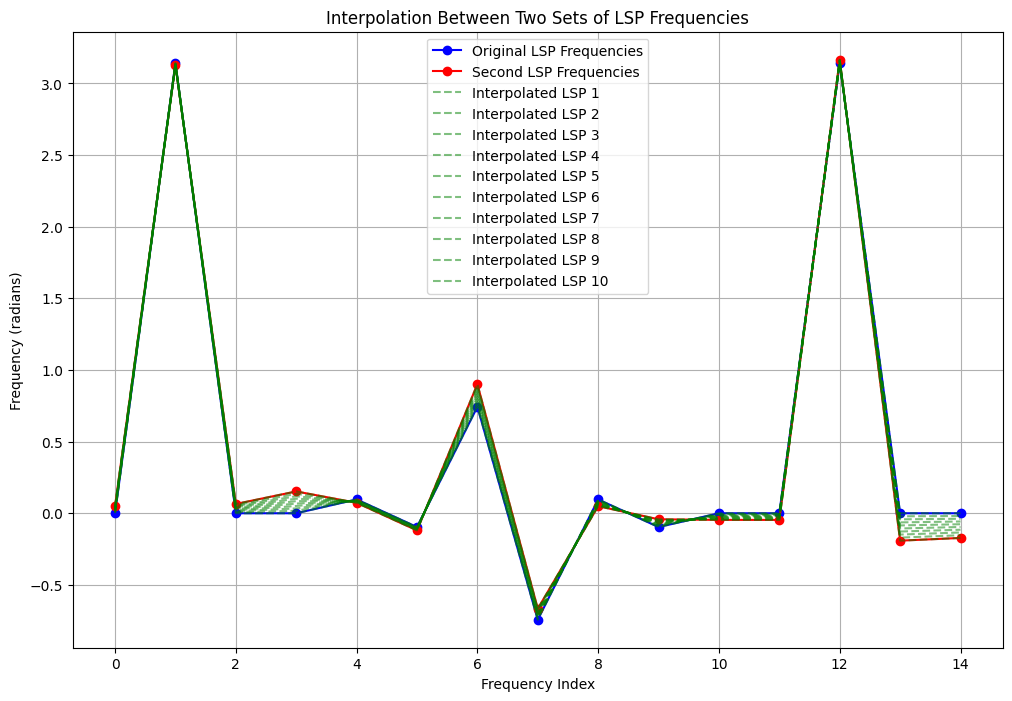

In [15]:
# Load a real audio signal
file_path = "speech_samples/speech_test_02.wav"

sample_rate, audio_signal = wavfile.read(file_path)  # Change this path to your .wav file
if audio_signal.ndim > 1:  # If stereo, convert to mono by averaging the channels
    audio_signal = np.mean(audio_signal, axis=1)

# Define LPC order
order = 14  # You can adjust the LPC order as needed

# Step 1: Calculate LPC coefficients using autocorrelation method
n = len(audio_signal)
r = np.correlate(audio_signal, audio_signal, mode='full')[n-1:]
R = r[:order + 1]
A = np.zeros(order + 1)
E = np.zeros(order + 1)
A[0] = 1.0
E[0] = R[0]

for i in range(1, order + 1):
    k = R[i]
    for j in range(1, i):
        k -= A[j] * R[i-j]
    k /= E[i-1]
    A[i] = k
    for j in range(1, i):
        A[j] -= k * A[i-j]
    E[i] = (1 - k * k) * E[i-1]

# Step 2: Convert LPC to LSP
# Normalize LPC coefficients
if A[0] != 1:
    A /= A[0]

# Create reversed coefficients
rev_coeffs = np.flipud(A)

# Initialize P and Q polynomials
P = np.zeros(order + 2)
Q = np.zeros(order + 2)

# Construct P polynomial
P[0:order + 1] = A
P[order + 1:] = 0
P += np.concatenate((rev_coeffs, [0]))
P /= 2

# Construct Q polynomial
Q[0:order + 1] = A
Q[order + 1:] = 0
Q -= np.concatenate((rev_coeffs, [0]))
Q /= 2

# Step 3: Calculate LSP frequencies from LPC
lsp_frequencies = np.angle(np.roots(P))

# Step 4: Create another set of LSP frequencies (for example purposes)
# Here we can create an arbitrary second set of LSP frequencies
lsp_frequencies_2 = lsp_frequencies + np.random.normal(0, 0.1, size=lsp_frequencies.shape)

# Step 5: Interpolate between the two sets of LSP frequencies
num_interpolations = 10  # Number of interpolated sets
interpolated_lsp_sets = []

for alpha in np.linspace(0, 1, num_interpolations):
    interpolated_lsp = (1 - alpha) * lsp_frequencies + alpha * lsp_frequencies_2
    interpolated_lsp_sets.append(interpolated_lsp)

# Step 6: Visualize results
plt.figure(figsize=(12, 8))

# Plot original LSP frequencies
plt.plot(lsp_frequencies, 'bo-', label='Original LSP Frequencies')

# Plot second LSP frequencies
plt.plot(lsp_frequencies_2, 'ro-', label='Second LSP Frequencies')

# Plot interpolated LSP frequencies
for i, interp_lsp in enumerate(interpolated_lsp_sets):
    plt.plot(interp_lsp, 'g--', alpha=0.5, label=f'Interpolated LSP {i+1}')

plt.title('Interpolation Between Two Sets of LSP Frequencies')
plt.xlabel('Frequency Index')
plt.ylabel('Frequency (radians)')
plt.legend()
plt.grid()
plt.show()
